In [1]:
import tensorflow as tf
from PIL import Image
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import re
import datetime
import time

# Load the TensorBoard notebook extension
%load_ext tensorboard

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
# Constats 

CLASS_NUM = 14
CWD = os.getcwd()
IMG_HEIGHT = 128
IMG_WIDTH = 128
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [22]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [23]:
# Load data

SLICE = 4000

train_images = open(f"{CWD}/sunrgbd_training_images.txt").read().splitlines()
test_images = open(f"{CWD}/sunrgbd_testing_images.txt").read().splitlines()

train_images.extend(test_images[:SLICE])
test_images = test_images[SLICE:]

TRAIN_IMG_COUNT = len(train_images)
TEST_IMG_COUNT = len(test_images)

train_labels = list(map(lambda x: f"{CWD}/train_labels/{x}", sorted_alphanumeric(os.listdir(f"{CWD}/train_labels"))))   
test_labels = list(map(lambda x: f"{CWD}/test_labels/{x}", sorted_alphanumeric(os.listdir(f"{CWD}/test_labels"))))  

train_labels.extend(test_labels[:SLICE])
test_labels = test_labels[SLICE:]

print(f"Train dataset size: {TRAIN_IMG_COUNT}. Test dataset size: {TEST_IMG_COUNT}")

Train dataset size: 9285. Test dataset size: 1050


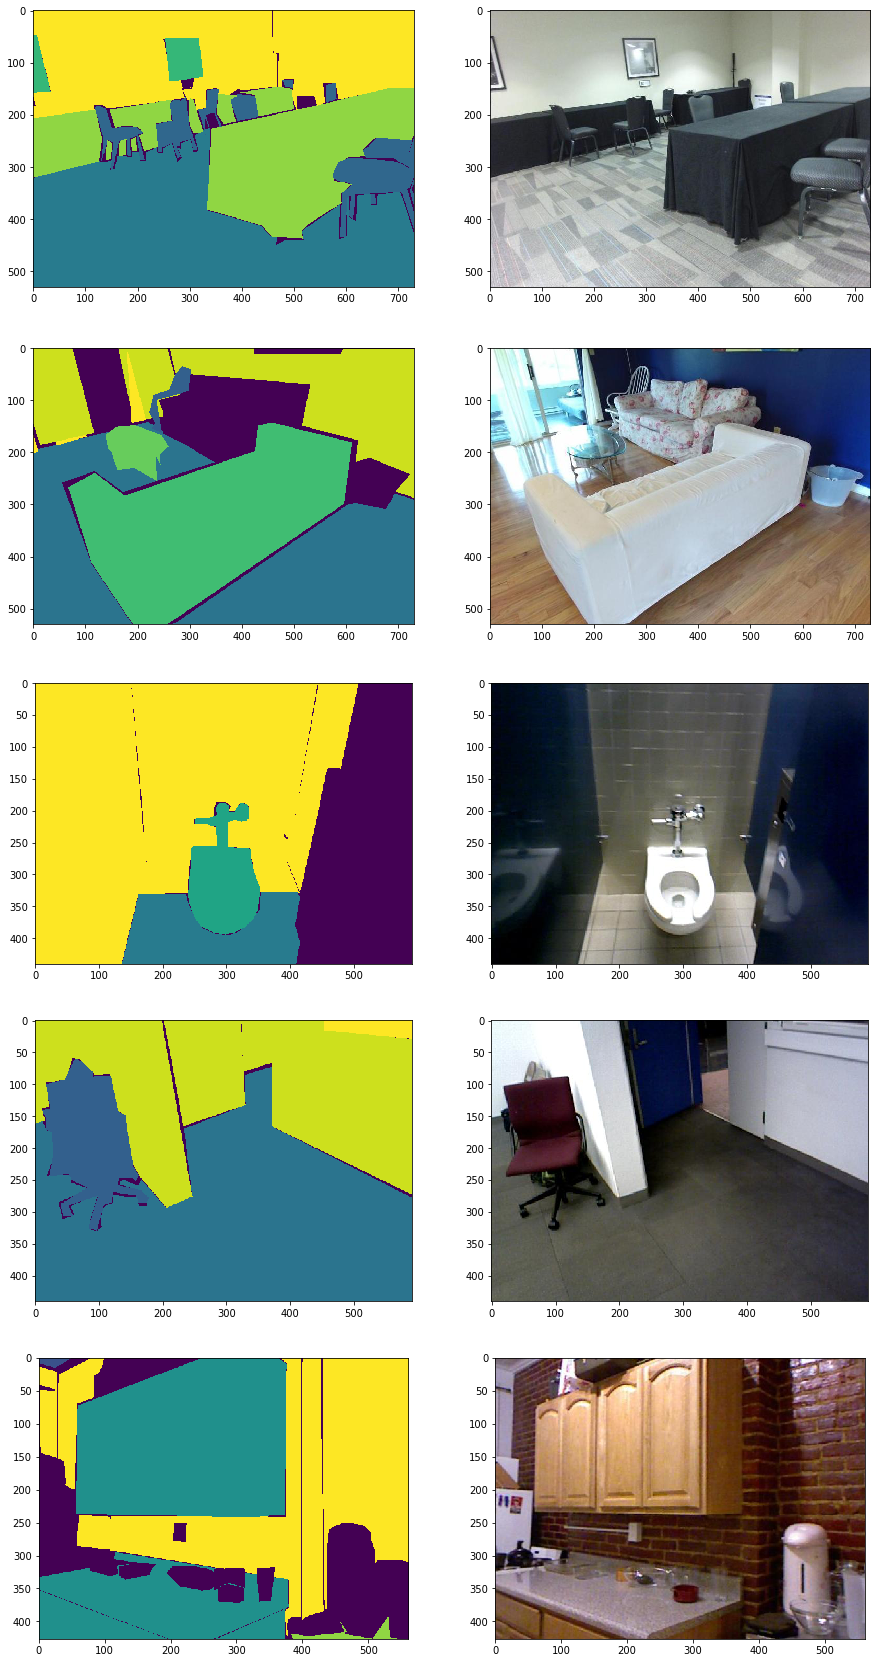

In [24]:
pairs = 5
indexes = [np.random.choice(range(TRAIN_IMG_COUNT)) for _ in range(pairs)]
f, axarr = plt.subplots(pairs, 2, figsize=(15,30))
for i, im in enumerate(indexes):
    label_image = Image.open(train_labels[im]) 
    label_image_arr = np.asarray(label_image)
    raw_image = Image.open(train_images[im]) 
    raw_image_arr = np.asarray(raw_image)
    axarr[i,0].imshow(label_image_arr)
    axarr[i,1].imshow(raw_image_arr)
plt.show()

In [25]:
def gen(): 
    for i in range(TRAIN_IMG_COUNT):
        label_image = Image.open(train_labels[i]) 
        label_image_arr = np.asarray(label_image)
        label_image_arr = np.expand_dims(label_image_arr, axis=2)
        raw_image = Image.open(train_images[i]) 
        raw_image_arr = np.asarray(raw_image)
        yield (raw_image_arr, label_image_arr)

dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int64, tf.int64),
                                         (tf.TensorShape([None, None, 3]), tf.TensorShape([None, None, 1]))) 
 
list(dataset.take(1).as_numpy_iterator())[0][0][0], list(dataset.take(1).as_numpy_iterator())[0][1][:2]

(array([[215, 230, 227],
        [215, 230, 227],
        [215, 230, 227],
        ...,
        [ 64,  64,  62],
        [ 60,  59,  57],
        [ 89,  88,  84]]),
 array([[[12],
         [12],
         [12],
         ...,
         [12],
         [12],
         [12]],
 
        [[12],
         [12],
         [12],
         ...,
         [ 8],
         [12],
         [12]]]))

In [26]:
# Unique shapes
# unique_shapes = {}

# for img in train_images:
#     im = cv2.imread(img)
#     shape = im.shape
#     if shape not in unique_shapes:
#         unique_shapes[str(shape)] = 1

# for k,v in unique_shapes.items():
#     print(k)

In [27]:
# Normalize, preprocess data functions

@tf.function
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

@tf.function
def load_image_train(image, mask):
    input_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

    # small augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return normalize(input_image), input_mask

@tf.function
def load_image_test(image, mask):
    input_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

    return normalize(input_image), input_mask

In [28]:
# Apply normalization

train = dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset.map(load_image_test)

# Split data into smaller batches
#  - Gradient descent on bathes
#  - Could be parallelized on multiple GPUs
#  - Faster training, requires less memory

BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_IMG_COUNT // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)

# 'value' is a tensor with shape [5, 30]
# Split 'value' into 3 tensors with sizes [4, 15, 11] along dimension 1
# test_dataset, val_dataset = tf.split(rest_dataset, [TEST_IMG_COUNT*0.1,TEST_IMG_COUNT*0.9], 1)
 
# Smaller dataset for initial experiment to overfit the data and make
# sure that model is learning properly before diving in real training

SMALL_DATASET_SIZE = 64
SMALL_BATCH_SIZE = 8
SMALL_BUFFER_SIZE = 100
SMALL_STEPS_PER_EPOCH = SMALL_DATASET_SIZE // SMALL_BATCH_SIZE

small_train = train.take(SMALL_DATASET_SIZE)
small_train_dataset = small_train.cache().shuffle(SMALL_BUFFER_SIZE).batch(SMALL_BATCH_SIZE).repeat()
small_train_dataset = small_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [29]:
# Pick a pretrained model for encoder

densenet = tf.keras.applications.DenseNet201(input_shape=INPUT_SHAPE, include_top=False)
densenet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

                                                                 conv5_block28_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block29_0_bn (BatchNormal (None, 4, 4, 1792)   7168        conv5_block28_concat[0][0]       
__________________________________________________________________________________________________
conv5_block29_0_relu (Activatio (None, 4, 4, 1792)   0           conv5_block29_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block29_1_conv (Conv2D)   (None, 4, 4, 128)    229376      conv5_block29_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block29_1_bn (BatchNormal (None, 4, 4, 128)    512         conv5_block29_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_bloc

# Densenet architectures

<img src="images/densenet.png" width="800">

In [72]:
# Use the activations of these layers
# These are used later to improve up-sampling by so called skip ?
layers = [densenet.get_layer(name).output for name in [
    "conv1/relu",            
    "conv2_block6_concat",  
    "conv3_block12_concat",  
    "conv4_block48_concat",           
    "conv5_block32_2_conv"  
]]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=densenet.input, outputs=layers)
down_stack.trainable = False

In [81]:
def upsample(filters, size, apply_dropout=False):
    """Upsamples an input.
  
      Conv2DTranspose => Batchnorm => Dropout => Relu
  
      Args:
        filters: number of filters
        size: filter size
        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
        apply_dropout: If True, adds the dropout layer
      
      Returns:
        Upsample Sequential Model
    """


    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

#     result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [82]:
def AttentionBlock(x,shortcut,i_filters):
    g1 = tf.keras.layers.Conv2D(i_filters,kernel_size = 1)(shortcut) 
    g1 = tf.keras.layers.BatchNormalization()(g1)
    x1 = tf.keras.layers.Conv2D(i_filters,kernel_size = 1)(x) 
    x1 = tf.keras.layers.BatchNormalization()(x1)

    g1_x1 = tf.keras.layers.Add()([g1,x1])
    psi = tf.keras.layers.Activation('relu')(g1_x1)
    psi = tf.keras.layers.Conv2D(1,kernel_size = 1)(psi) 
    psi = tf.keras.layers.BatchNormalization()(psi)
    psi = tf.keras.layers.Activation('sigmoid')(psi)
    x = tf.keras.layers.Multiply()([x,psi])
    return x

# Upsampling procedure 

Instead of regular convolution operation, we multiply lower dimension cell with the filter and sum those values in projected bigger picture. 

![title](images/upsample.gif)

In [95]:
# Defining U-net architecture 

up_stack = [
    upsample(1792, 3),  
    upsample(512,  3),  
    upsample(256,  3),
    upsample(64,   3),
]

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = inputs

# Downsampling through the model
skips = down_stack(x)
x = skips[-1]
skips = reversed(skips[:-1])

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    print(x.shape[-1])
#     x = AttentionBlock(x, skip, 64)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = tf.keras.layers.BatchNormalization()(x)

# This is the last layer of the model
x = tf.keras.layers.Conv2DTranspose(CLASS_NUM, 3, strides=2, padding='same')(x)  # 64x64 -> 128x128
unet = tf.keras.Model(inputs=inputs, outputs=x) 

1792
512
256
64


# Unet 

![image](images/unet.jpg)

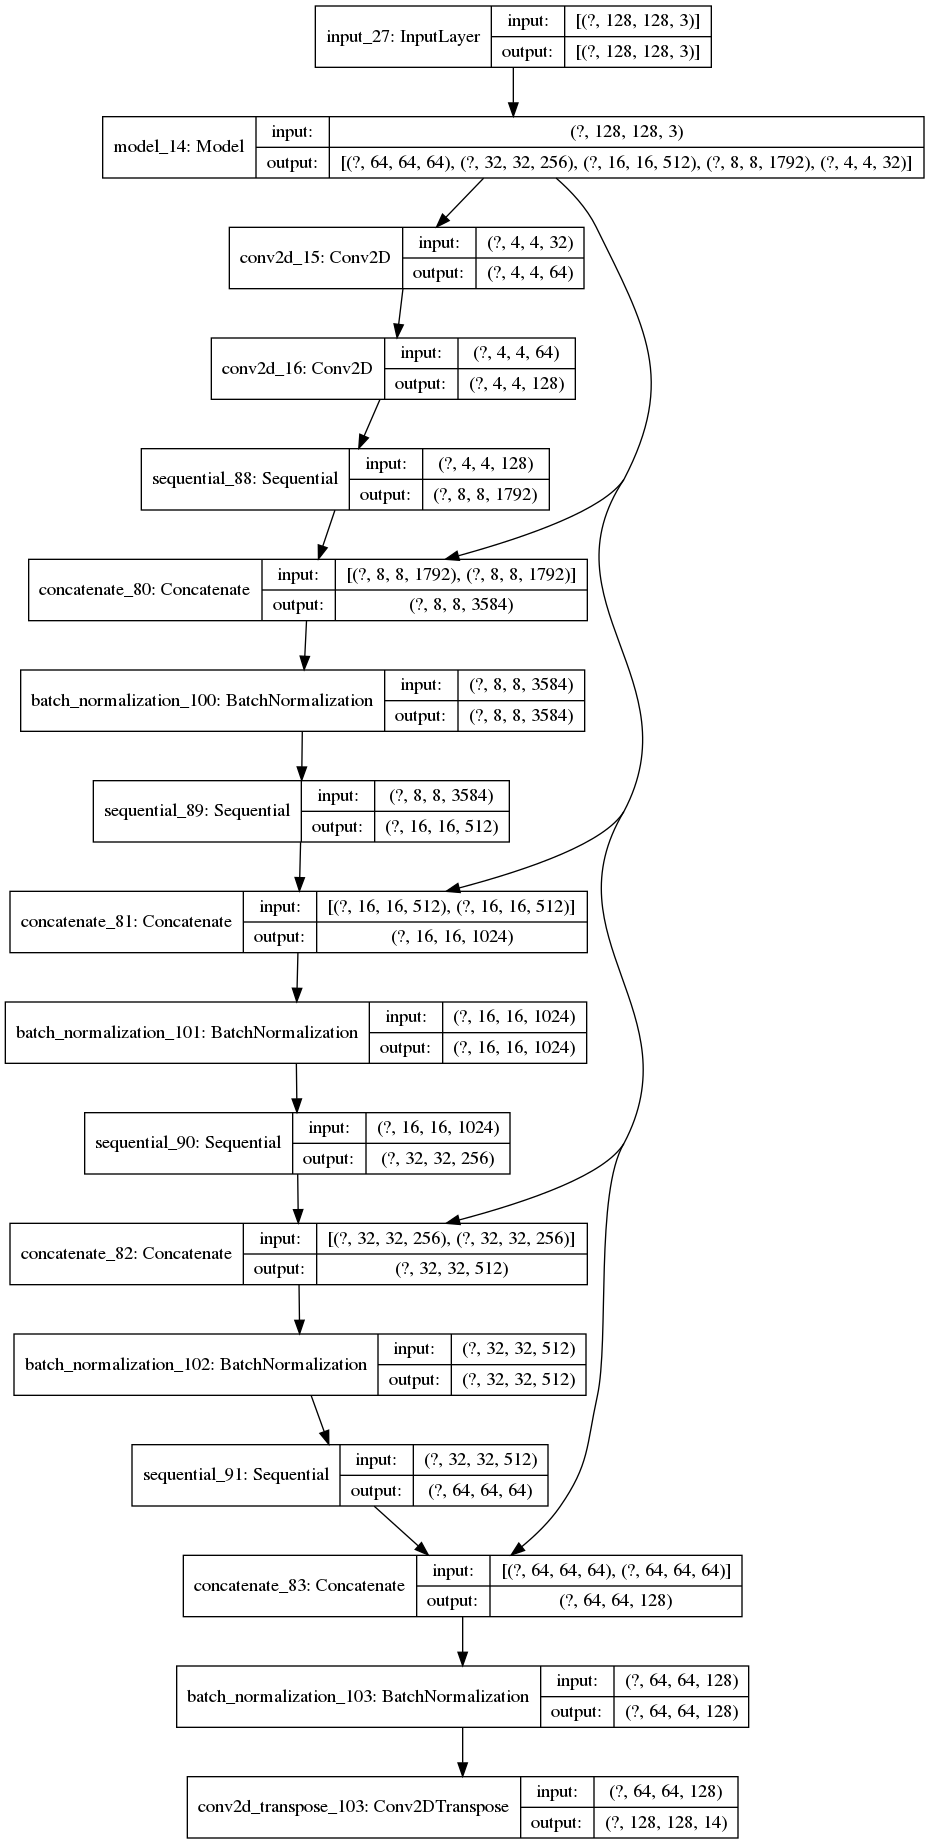

In [91]:
# Consider bigger learning rate ?
opt = tf.keras.optimizers.Adam(0.001)
# opt = LAMB()

unet.compile(optimizer=opt,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

INITIAL_WEIGHTS = unet.get_weights()

# Cool visualization 
tf.keras.utils.plot_model(unet, show_shapes=True)

In [92]:
# Display pair from dataset object

def display_images(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=3):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask, create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

# Check current state of the model
# show_predictions(test_dataset)

In [93]:
# Fit callbacks

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        display.clear_output(wait=True)
        show_predictions(test_dataset, 1)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()

        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        
        if val_loss == None:
            print("Missing val_loss")
            return
        
        if np.less(val_loss, self.best):
            self.best = val_loss
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print('\nRestoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print('\nEpoch %05d: early stopping' % (self.stopped_epoch + 1))
        self.model.set_weights(self.best_weights)
        self.model.save_weights(f"./checkpoints/cp_best_model")
        
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                            log_dir=f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}", 
                            histogram_freq=1, 
                            update_freq='batch')

In [94]:
# Overfit a small dataset

EPOCHS = 10
VALIDATION_STEPS = 1

model_history = unet.fit(small_train_dataset, epochs=EPOCHS, 
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_dataset,
                         steps_per_epoch=SMALL_STEPS_PER_EPOCH)

Train for 8 steps, validate for 1 steps
Epoch 1/10
8/8 [==============================] - 54s 7s/step - loss: 2.4544 - accuracy: 0.2343 - val_loss: 2.5809 - val_accuracy: 0.3236
Epoch 2/10
8/8 [==============================] - 42s 5s/step - loss: 1.9268 - accuracy: 0.4732 - val_loss: 2.4950 - val_accuracy: 0.4216
Epoch 3/10
8/8 [==============================] - 40s 5s/step - loss: 1.5582 - accuracy: 0.5856 - val_loss: 2.4430 - val_accuracy: 0.3409
Epoch 4/10
8/8 [==============================] - 39s 5s/step - loss: 1.2865 - accuracy: 0.6665 - val_loss: 2.4855 - val_accuracy: 0.2351
Epoch 5/10
8/8 [==============================] - 39s 5s/step - loss: 1.0812 - accuracy: 0.7252 - val_loss: 2.5339 - val_accuracy: 0.2568
Epoch 6/10
6/8 [=====================>........] - ETA: 4s - loss: 0.8583 - accuracy: 0.8011

KeyboardInterrupt: 

In [35]:
# Cross validate learning rate on small dataset

EPOCHS = 10
VALIDATION_STEPS = 1

for _ in range(10):
    np.random.seed(int(time.time()))
    lr = 10**np.random.uniform(-4, -2)
    
    print(f"Testing learning rate: {lr}")

    unet.compile(optimizer=tf.keras.optimizers.Adam(lr),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])
    
    unet.set_weights(INITIAL_WEIGHTS)

    model_history = unet.fit(small_train_dataset, epochs=EPOCHS, 
                             validation_steps=VALIDATION_STEPS,
                             validation_data=test_dataset,
                             steps_per_epoch=SMALL_STEPS_PER_EPOCH)

Testing learning rate: 0.0006702651025572108
Train for 8 steps, validate for 1 steps
Epoch 1/10
8/8 [==============================] - 42s 5s/step - loss: 2.5480 - accuracy: 0.1655 - val_loss: 2.5637 - val_accuracy: 0.2249
Epoch 2/10
8/8 [==============================] - 27s 3s/step - loss: 2.2215 - accuracy: 0.3429 - val_loss: 2.4687 - val_accuracy: 0.3195
Epoch 3/10
8/8 [==============================] - 30s 4s/step - loss: 1.9815 - accuracy: 0.4027 - val_loss: 2.3878 - val_accuracy: 0.3737
Epoch 4/10
8/8 [==============================] - 36s 4s/step - loss: 1.8026 - accuracy: 0.4542 - val_loss: 2.3032 - val_accuracy: 0.4124
Epoch 5/10
8/8 [==============================] - 29s 4s/step - loss: 1.6592 - accuracy: 0.4938 - val_loss: 2.2164 - val_accuracy: 0.4477
Epoch 6/10
8/8 [==============================] - 28s 3s/step - loss: 1.5195 - accuracy: 0.5354 - val_loss: 2.2343 - val_accuracy: 0.3909
Epoch 7/10
8/8 [==============================] - 29s 4s/step - loss: 1.4022 - accuracy

KeyboardInterrupt: 

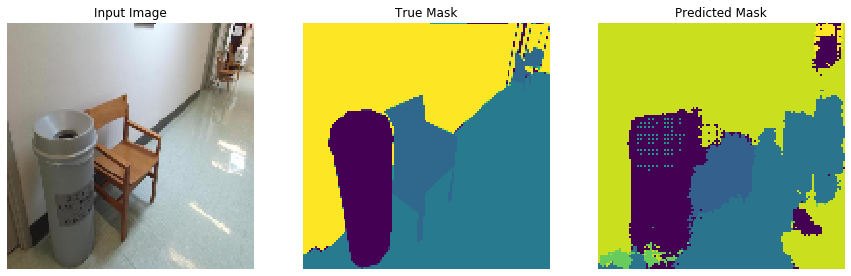


Sample Prediction after epoch 3

Missing val_loss
 2/82 [..............................] - ETA: 23:47 - loss: 1.2329 - accuracy: 0.5853

KeyboardInterrupt: 

In [30]:
# Reset initial state, discard overfitted weights

unet.set_weights(INITIAL_WEIGHTS)

# Train on whole dataset

EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_IMG_COUNT // BATCH_SIZE // VAL_SUBSPLITS

# Validation_steps - Total number of steps to draw before stopping when performing
#                    validation at the end of every epoch.

model_history = unet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback, EarlyStoppingAtMinLoss(5)])

In [28]:
# Tensorboard for model statistics visualization 

%tensorboard --logdir logs/fit

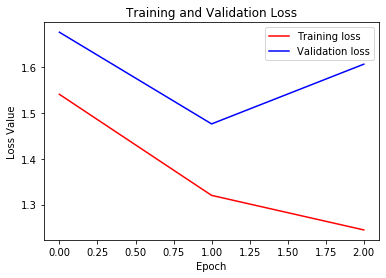

In [31]:
# Plot the loss

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
# Test model

show_predictions(test_dataset, 3)

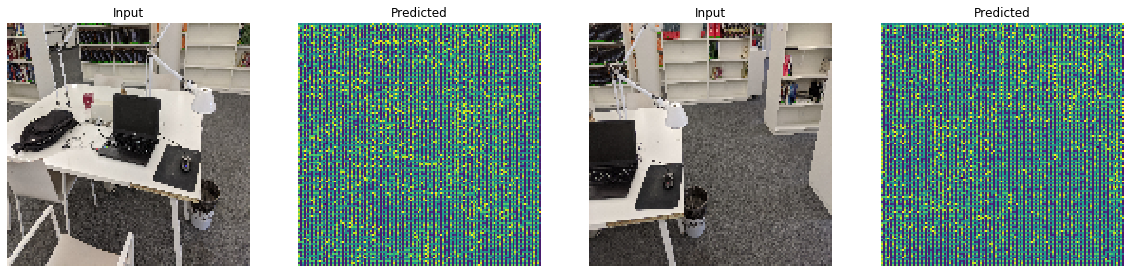

In [50]:
# Test on my pictures

val_image_1 = Image.open(f"{CWD}/my_val/1.jpg") 
val_image_1 = np.asarray(val_image_1)
val_image_2 = Image.open(f"{CWD}/my_val/2.jpg") 
val_image_2 = np.asarray(val_image_2)

val_image_1 = normalize(val_image_1)
val_image_2 = normalize(val_image_2)

val_image_1 = tf.image.resize(val_image_1, (128, 128))
val_image_2 = tf.image.resize(val_image_2, (128, 128))

val_images = [val_image_1, val_image_2]

plt.figure(figsize=(20, 15))
i = 1
for im in range(2):
    plt.subplot(1, 4, i)
    i += 1
    plt.title("Input")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(val_images[im]))
    plt.axis('off')
    plt.subplot(1, 4, i)
    i += 1
    plt.title("Predicted")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(create_mask(unet.predict(val_images[im][tf.newaxis, ...]))))
    plt.axis('off')
plt.show()

### After 3 epochs

Parameters:
<ul>
    <li>Learning rate: 0.01</li> 
    <li>Two dropout layers</li>
    <li>Batch size: 32</li>
</ul>
    
    
![losses](images/after_3_epochs.png)